## Libraries



In [1]:
!pip install jax

In [26]:
import jax
import jax.numpy as jnp
from jax import random
from jax import jit, vmap, grad
# from scipy.stats import norm

In [27]:
from sklearn.metrics import brier_score_loss

import matplotlib.pylab as plt
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.metrics import roc_auc_score, confusion_matrix

In [28]:
import numpy as np

# Problem:

Our goal is to demonstrate that the (proper) scoring rules, such as Brier score are not sufficent to establish trusthworthiness and perform model trusthworthiness comoparison.

We will demonstrate that a model that is trusthworthy in a specific decision-making task can have higher Brier score than a model with is untrusthworthy.??

*We wish to demonstrate that a model that is trustworthy in a specific decision-making task can have a lower brier score than a model which is untrustworthy. *

Suppose the following generative model,

In [55]:
def generate_simulated_data(sample_size, key):

    key1, key2, key3, key4 = random.split(key, 4)

    X1 = random.normal(key1, shape=(sample_size,))
    X2 = random.normal(key2, shape=(sample_size,))
    X3 = random.normal(key3, shape=(sample_size,))

    Xbar = 0.5 * X1 - X2 + 0.5 * X3
    p = jax.nn.sigmoid(Xbar)

    y_true = random.bernoulli(key4, p, shape=(sample_size,))
    y_true = jnp.where(y_true == False, 0, 1)

    Xbar = 0.5 * X1 - X2 + 0.5 * X3 + 1.0
    p_1 = jax.nn.sigmoid(Xbar)

    Xbar = 0.5 * X1 - X2
    p_2 = jax.nn.sigmoid(Xbar)

    return y_true, p, p_1, p_2

def test_scores(y_true, p):
    bs = jnp.mean((y_true - p)**2)
    #auc = roc_auc_score(y_true, p) [this is not jax parallelizable?!]
    return bs #, auc

def utility01(y_true, p, threshold):
    decision = jnp.where(p >= threshold, 1, 0)
    return jnp.mean(jnp.where(decision == y_true, 1, 0))

def utility_gen(y_true,p, threshold):
    cost =  jnp.array([5, 7, 1, 10])
    decision = jnp.where(p >= threshold, 1, 0)
    tp = jnp.sum(jnp.where(y_true==1, jnp.where(decision==1,1,0) , 0))
    tn = jnp.sum(jnp.where(y_true==0, jnp.where(decision==0,1,0) , 0))
    fp = jnp.sum(jnp.where(y_true==0, jnp.where(decision==1,1,0) , 0))
    fn = jnp.sum(jnp.where(y_true==1, jnp.where(decision==0,1,0) , 0))
    loss= (-cost[2]*tp + -cost[3]*tn + cost[0]*fn + cost[1]*fp)
    expected_loss= -loss/(tn+fp+fn+tp)
    return expected_loss




In [7]:
def NetTrustScore(y_true, p):
    alpha = 1.0
    beta = 1.0

    y_hat = jnp.where(p >= 0.5, 1, 0)
    A = jnp.sum(jnp.power(jnp.where(y_hat == y_true, p, 0), alpha))
    B = jnp.sum(jnp.power(jnp.where(y_hat != y_true, 1.0 - p, 0), beta))

    return ( A + B ) / y_true.shape[0]

In [30]:
# Simulator
sample_size = 15000
key = random.PRNGKey(50232)  # Seed the initial key

y_true, p, p1, p2 = generate_simulated_data(sample_size, key)

print(y_true)
print(p)
print(p1)
print(p2)

print("Brier Score (Bayes Classifier):", test_scores(y_true, p))
print("Brier Score (Bayes-equivalent Classifier):", test_scores(y_true, p1))
print("Brier Score (Calibrated Classifier):", test_scores(y_true, p2))

print("Utility Score (Bayes Classifier, th=0.5):", utility01(y_true, p, 0.5))
print("Utility Score (Bayes-equivalent Classifier, th=0.5):", utility01(y_true, p1, 0.5))
print("Utility Score (Calibrated Classifier, th=0.5):", utility01(y_true, p2, 0.5))

print("Utility Score (Bayes Classifier, th=0.5):", utility_gen(y_true, p, 0.5))
print("Utility Score (Bayes-equivalent Classifier, th=0.5):", utility_gen(y_true, p1, 0.5))
print("Utility Score (Calibrated Classifier, th=0.5):", utility_gen(y_true, p2, 0.5))

[0 1 1 ... 0 1 1]
[0.22247286 0.75793004 0.4342899  ... 0.19819799 0.34405258 0.55228716]
[0.43750027 0.894859   0.67603964 ... 0.40189025 0.5877602  0.7702841 ]
[0.24315268 0.6992837  0.475386   ... 0.29639038 0.33980158 0.47204176]
Brier Score (Bayes Classifier): 0.19167705
Brier Score (Bayes-equivalent Classifier): 0.22664262
Brier Score (Calibrated Classifier): 0.20223337
Utility Score (Bayes Classifier, th=0.5): 0.7094667
Utility Score (Bayes-equivalent Classifier, th=0.5): 0.64093333
Utility Score (Calibrated Classifier, th=0.5): 0.68313336
Utility Score (Bayes Classifier, th=0.5): 2.1209333
Utility Score (Bayes-equivalent Classifier, th=0.5): -0.31133333
Utility Score (Calibrated Classifier, th=0.5): 1.8030666


# Calibration Plot

/var/folders/cm/3djk6lh16jx8s5wnl01pttbw0000gn/T/ipykernel_27268/3460406595.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("Dark2")
/Users/ritwikvashistha/anaconda3/envs/cv/lib/python3.10/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]
/Users/ritwikvashistha/anaconda3/envs/cv/lib/python3.10/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_

(0.0, 1.0)

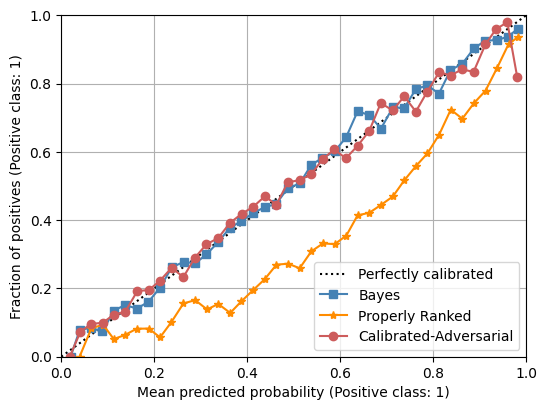

In [41]:
fig = plt.figure(figsize=(6, 6))
colors = plt.cm.get_cmap("Dark2")

gs = GridSpec(4, 2)
ax_calibration_curve = fig.add_subplot(gs[:3, :3])

disp = CalibrationDisplay.from_predictions(y_true, p, n_bins=40, color='steelblue', name="Bayes", ax=ax_calibration_curve)
disp = CalibrationDisplay.from_predictions(y_true, p1, n_bins=40, color='darkorange', name="Properly Ranked", ax=ax_calibration_curve,marker='*')
disp = CalibrationDisplay.from_predictions(y_true, p2, n_bins=40, color='indianred', name="Calibrated-Adversarial", ax=ax_calibration_curve, marker='o')
# ax_calibration_curve.set_title("Calibration plots")

plt.grid()
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)

#plt.show()

# Brier and NetTrust Score

Now let's generate many simulations

In [10]:
simulations_vamp = vmap(generate_simulated_data, in_axes=(None, 0))
scores_vamp = vmap(test_scores, in_axes=(0, 0))
NetTrustScore_vamp=vmap(NetTrustScore, in_axes=(0, 0))
utility01_th_array = vmap(utility01, in_axes=(None, None, 0))

In [11]:
# parameters
sample_size = 5000
Nsims = 3000 # Number of samples from the posterior
num_keys = Nsims  # Number of random keys needed

key = random.PRNGKey(50232)  # Seed the initial key
keys = random.split(key, num_keys)  # Generate a vector of random keys

In [12]:
y_true, p, p1, p2 = simulations_vamp(sample_size, keys)

score_bayes = scores_vamp(y_true, p)
score_bayes_eq = scores_vamp(y_true, p1)
score_calibrated_adv = scores_vamp(y_true, p2)

NetTrustScore_bayes = NetTrustScore_vamp(y_true, p)
NetTrustScore_bayes_eq = NetTrustScore_vamp(y_true, p1)
NetTrustScore_calibrated_adv = NetTrustScore_vamp(y_true, p2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


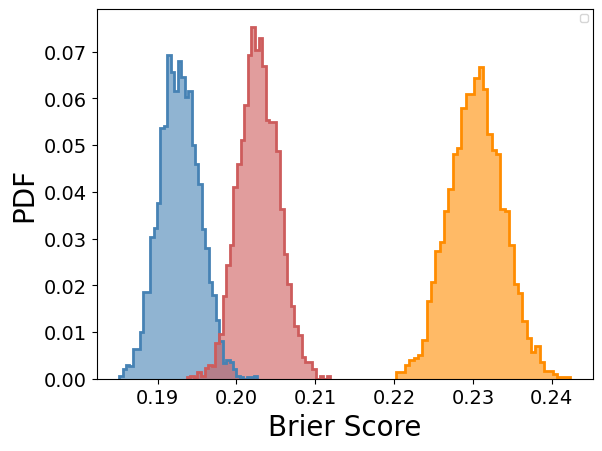

In [43]:
weights = np.ones_like(score_bayes) / len(score_bayes)
_ = plt.hist(score_bayes, bins=40, color='steelblue', alpha=0.6,weights=weights)
_ = plt.hist(score_bayes, bins=40, color='steelblue', histtype='step', lw=2.0, weights=weights)

weights = np.ones_like(score_bayes_eq) / len(score_bayes_eq)
_ = plt.hist(score_bayes_eq, bins=40, alpha=0.6, color='darkorange' ,weights=weights)
_ = plt.hist(score_bayes_eq, bins=40, color='darkorange', histtype='step', lw=2.0,weights=weights)

weights = np.ones_like(score_calibrated_adv) / len(score_calibrated_adv)
_ = plt.hist(score_calibrated_adv, bins=40, alpha=0.6, color='indianred' ,weights=weights)
_ = plt.hist(score_calibrated_adv, bins=40, color='indianred', histtype='step', lw=2.0,weights=weights)

plt.xlabel('Brier Score', size=20)
plt.ylabel('PDF', size=20)
plt.xticks(size=14)
plt.yticks(size=14)

plt.legend(loc=1, prop={'size':7})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


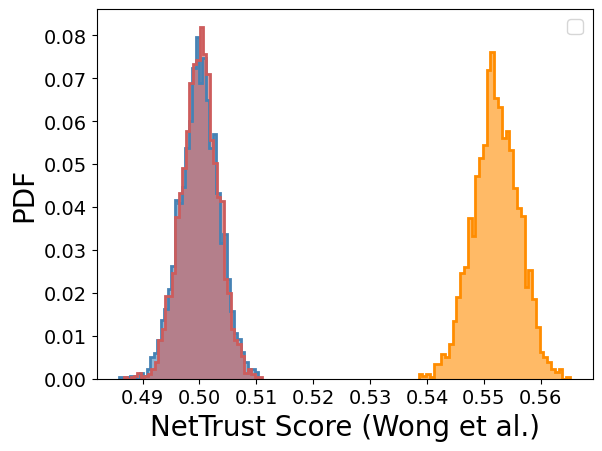

In [44]:
weights = np.ones_like(NetTrustScore_bayes) / len(NetTrustScore_bayes)
_ = plt.hist(NetTrustScore_bayes, bins=40, color='steelblue', alpha=0.6,weights=weights)
_ = plt.hist(NetTrustScore_bayes, bins=40, color='steelblue', histtype='step', lw=2.0,weights=weights)

weights = np.ones_like(NetTrustScore_bayes_eq) / len(NetTrustScore_bayes_eq)
_ = plt.hist(NetTrustScore_bayes_eq, bins=40, alpha=0.6, color='darkorange',weights=weights)
_ = plt.hist(NetTrustScore_bayes_eq, bins=40, color='darkorange', histtype='step', lw=2.0,weights=weights)

weights = np.ones_like(NetTrustScore_calibrated_adv) / len(NetTrustScore_calibrated_adv)
_ = plt.hist(NetTrustScore_calibrated_adv, bins=40, alpha=0.6, color='indianred',weights=weights)
_ = plt.hist(NetTrustScore_calibrated_adv, bins=40, color='indianred', histtype='step', lw=2.0,weights=weights)

plt.xlabel('NetTrust Score (Wong et al.)', size=20)
plt.ylabel('PDF', size=20)
plt.xticks(size=14)
plt.yticks(size=14)

plt.legend(loc=1, prop={'size':14})

#Accuracy

In [15]:
accuracy_vmap = vmap(utility01, in_axes=(0, 0, None))

In [16]:
# parameters
sample_size = 2000
Nsims = 400 # Number of samples from the posterior
num_keys = Nsims  # Number of random keys needed

key = random.PRNGKey(50232)  # Seed the initial key
keys = random.split(key, num_keys)  # Generate a vector of random keys

In [17]:
y_true, p, p1, p2 = simulations_vamp(sample_size, keys)
acc_bayes = accuracy_vmap(y_true, p, 0.5)
acc_bayes_equiv = accuracy_vmap(y_true, p1, 0.5)
acc_cal_adv = accuracy_vmap(y_true, p2, 0.5)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


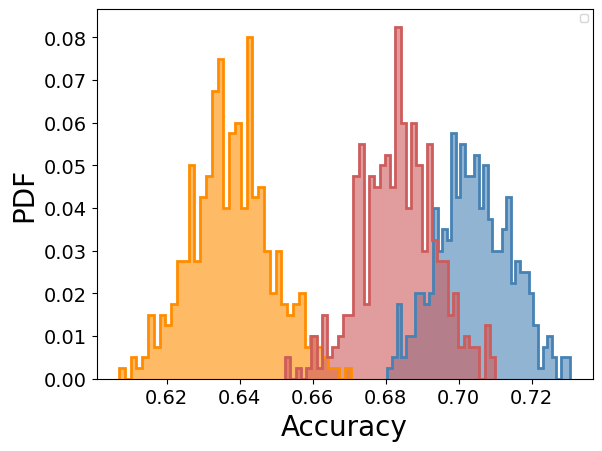

In [45]:
weights = np.ones_like(acc_bayes) / len(acc_bayes)
_ = plt.hist(acc_bayes, bins=40, color='steelblue', alpha=0.6, weights=weights)
_ = plt.hist(acc_bayes, bins=40, color='steelblue', histtype='step', lw=2.0, weights=weights)

weights = np.ones_like(acc_bayes_equiv) / len(acc_bayes_equiv)
_ = plt.hist(acc_bayes_equiv, bins=40, alpha=0.6, color='darkorange', weights=weights)
_ = plt.hist(acc_bayes_equiv, bins=40, color='darkorange', histtype='step', lw=2.0, weights=weights)

weights = np.ones_like(acc_cal_adv) / len(acc_cal_adv)
_ = plt.hist(acc_cal_adv, bins=40, alpha=0.6, color='indianred', weights=weights)
_ = plt.hist(acc_cal_adv, bins=40, color='indianred', histtype='step', lw=2.0, weights=weights)

plt.xlabel('Accuracy', size=20)
plt.ylabel('PDF', size=20)
plt.xticks(size=14)
plt.yticks(size=14)

plt.legend(loc=1, prop={'size':7})

# Utility Evaluation

In [57]:
utility_threshold_vmap_01 = vmap(utility01, in_axes=(None, None, 0))
utility_threshold_vmap_gen = vmap(utility_gen, in_axes=(None, None, 0))
utility_sims_vmap_01 = vmap(utility_threshold_vmap_01, in_axes=(0, 0, None))
utility_sims_vmap_gen = vmap(utility_threshold_vmap_gen, in_axes=(0, 0, None))

In [58]:
# parameters
sample_size = 2000
Nsims = 400 # Number of samples from the posterior
num_keys = Nsims  # Number of random keys needed

key = random.PRNGKey(50232)  # Seed the initial key
keys = random.split(key, num_keys)  # Generate a vector of random keys

In [52]:
y_true, p, p1, p2 = simulations_vamp(sample_size, keys)
threshold_array = jnp.linspace(0.0, 1.0, 5001)
utility_bayes_01 = utility_sims_vmap_01(y_true, p, threshold_array)
utility_bayes_equiv_01 = utility_sims_vmap_01(y_true, p1, threshold_array)
utility_cal_adv_01 = utility_sims_vmap_01(y_true, p2, threshold_array)

In [59]:
utility_bayes_gen = utility_sims_vmap_gen(y_true, p, threshold_array)
utility_bayes_equiv_gen = utility_sims_vmap_gen(y_true, p1, threshold_array)
utility_cal_adv_gen = utility_sims_vmap_gen(y_true, p2, threshold_array)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, '0-1 Utility Function')

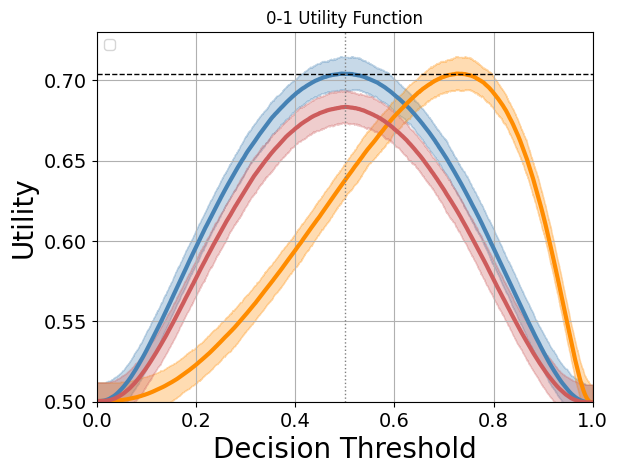

In [53]:
plt.plot(threshold_array, jnp.mean(utility_bayes_01, axis=0), lw=3.0, color='steelblue')
plt.fill_between(threshold_array, jnp.percentile(utility_bayes_01, 16, axis=0),
         jnp.percentile(utility_bayes_01, 84, axis=0), color='steelblue', alpha=0.3)

plt.plot(threshold_array, jnp.mean(utility_bayes_equiv_01, axis=0), lw=3.0, color='darkorange')
plt.fill_between(threshold_array, jnp.percentile(utility_bayes_equiv_01, 16, axis=0),
         jnp.percentile(utility_bayes_equiv_01, 84, axis=0), color='darkorange', alpha=0.3)

plt.plot(threshold_array, jnp.mean(utility_cal_adv_01, axis=0), lw=3.0, color='indianred')
plt.fill_between(threshold_array, jnp.percentile(utility_cal_adv_01, 16, axis=0),
         jnp.percentile(utility_cal_adv_01, 84, axis=0), color='indianred', alpha=0.3)

plt.axhline(y=jnp.max(jnp.mean(utility_bayes_01, axis=0)), linestyle='--', lw=1.0, color='black')
plt.axvline(x=0.5, linestyle=':', lw=1.0, color='grey')

plt.xlim(0.0, 1.0)
plt.ylim(0.5, 0.73)

plt.xticks(size=14)
plt.yticks(size=14)

plt.legend(loc=2, prop={'size':10})
plt.grid()

plt.ylabel('Utility', size=20)
plt.xlabel('Decision Threshold', size=20)
plt.title("0-1 Utility Function")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Generalized Utility Function')

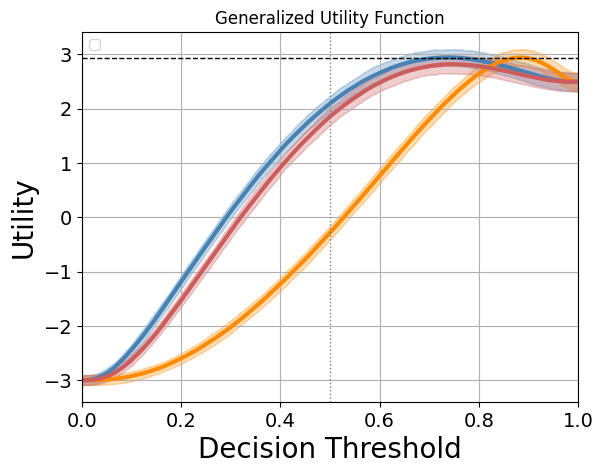

In [60]:
plt.plot(threshold_array, jnp.mean(utility_bayes_gen, axis=0), lw=3.0, color='steelblue')
plt.fill_between(threshold_array, jnp.percentile(utility_bayes_gen, 16, axis=0),
         jnp.percentile(utility_bayes_gen, 84, axis=0), color='steelblue', alpha=0.3)

plt.plot(threshold_array, jnp.mean(utility_bayes_equiv_gen, axis=0), lw=3.0, color='darkorange')
plt.fill_between(threshold_array, jnp.percentile(utility_bayes_equiv_gen, 16, axis=0),
         jnp.percentile(utility_bayes_equiv_gen, 84, axis=0), color='darkorange', alpha=0.3)

plt.plot(threshold_array, jnp.mean(utility_cal_adv_gen, axis=0), lw=3.0, color='indianred')
plt.fill_between(threshold_array, jnp.percentile(utility_cal_adv_gen, 16, axis=0),
         jnp.percentile(utility_cal_adv_gen, 84, axis=0), color='indianred', alpha=0.3)

plt.axhline(y=jnp.max(jnp.mean(utility_bayes_gen, axis=0)), linestyle='--', lw=1.0, color='black')
plt.axvline(x=0.5, linestyle=':', lw=1.0, color='grey')

plt.xlim(0.0, 1.0)

plt.xticks(size=14)
plt.yticks(size=14)

plt.legend(loc=2, prop={'size':10})
plt.grid()

plt.ylabel('Utility', size=20)
plt.xlabel('Decision Threshold', size=20)
plt.title("Generalized Utility Function")